In [1]:
from __future__ import annotations

from typing import NamedTuple, Sequence, Callable
import jax
from jax.tree_util import tree_map, tree_multimap
from jax import lax
import jax.numpy as np
import jax.random as random
import seaborn as sns

In [2]:
class Hand(NamedTuple):
  total: int = 0
  is_soft: bool = False

class TurnStep(NamedTuple):
  hand: Hand
  hit: bool
  is_game_over: bool
  new_hand: Hand

class Turn(NamedTuple):
  initial_cards: Sequence[int]
  initial_hand: Hand
  steps: Sequence[TurnStep]
  final_index: int
  final_hand: Hand

class EpisodeStep(NamedTuple):
  state: Tuple[int]
  action: Tuple[int]

class Episode(NamedTuple):
  final_step_index: int
  trajectory: Sequence[EpisodeStep]
  reward: float

In [3]:
def one_hot(length, index):
  encoded = np.eye(length)[index]
  return np.array(encoded, np.int32)
  
def tree_slice(index, tree):
  return tree_map(lambda x: x[index], tree)
  
def deal_card(rng: int):
  return random.choice(rng, np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 10, 10, 10]))

def deal_cards(rng: int, n):
  return list(map(deal_card, random.split(rng, n)))

def standard_dealer_policy(rng, i, hand: Hand) -> bool:
  return hand.total < 17

def add_card_to_hand(hand: Hand, card: int) -> Hand:
  total = hand.total
  total += card
  is_ace = card == 1
  convert_to_soft = is_ace & ~hand.is_soft & (total < 11)
  convert_to_hard = hand.is_soft & (total > 21)
  total += np.where(convert_to_soft, 10, 0)
  total -= np.where(convert_to_hard, 10, 0)
  is_soft = hand.is_soft
  is_soft |= convert_to_soft
  is_soft &= (~convert_to_hard)
  return Hand(total, np.array(is_soft, dtype=np.bool_))

def hand_from_cards(cards: Sequence[int]) -> Hand:
  hand = Hand()
  for card in cards:
    hand = add_card_to_hand(hand, card)
  return hand

def play_turn_step(policy, state, rng):
  i, active, hand = state
  rng, r = random.split(rng)
  hit = active & policy(rng, i, hand)
  rng, r = random.split(rng)
  card = np.where(hit, deal_card(r), 0)
  new_hand = add_card_to_hand(hand, card)
  is_game_over = ~hit | (new_hand.total > 21)
  next_active = active & hit & ~is_game_over
  return (i + 1, next_active, new_hand), TurnStep(hand, hit, is_game_over, new_hand)

def play_turn(rng, policy, steps_per_turn: int) -> Turn:
  rng, r = random.split(rng)
  initial_cards = deal_cards(r, 2)
  initial_hand = hand_from_cards(initial_cards)
  rng, r = random.split(rng)
  initial_state = (0, True, initial_hand)
  rngs = np.array(random.split(r, steps_per_turn))
  _play_turn_step = jax.partial(play_turn_step, policy)
  _, steps = lax.scan(_play_turn_step, initial_state, rngs)
  final_index = np.argmax(steps.is_game_over)
  final_hand = tree_slice(final_index, steps).new_hand
  return Turn(
      initial_cards=initial_cards,
      initial_hand=initial_hand,
      steps=steps,
      final_index=final_index,
      final_hand=final_hand)

def game_result(dealer_total, player_total):
  dealer_busts = dealer_total > 21
  player_busts = player_total > 21
  dealer_wins = ((dealer_total > player_total) & ~dealer_busts) | player_busts
  player_wins = ((player_total > dealer_total) & ~player_busts) | (dealer_busts & ~player_busts)
  return np.where(player_wins, 1, np.where(dealer_wins, -1, 0))

def state_to_index(dealer_shows, player_hand):
  return (
    np.array(player_hand.is_soft, np.int32),
    player_hand.total - 4,
    dealer_shows - 1)
  
def turn_step_to_episode_step(dealer_shows, turn_step):
  return EpisodeStep(
      state=state_to_index(dealer_shows, turn_step.hand),
      action=(np.array(turn_step.hit, np.int32),))
  
def generate_episode(rng, PI, steps_per_turn):
  rng, r = random.split(rng)
  dealer_turn = play_turn(r, standard_dealer_policy, steps_per_turn)
  dealer_shows = dealer_turn.initial_cards[0]

  def player_policy(rng, t, hand):
    exploring_action = random.choice(rng, np.array([False, True]))
    state = state_to_index(dealer_shows, hand)
    policy_action = np.array(PI[state], dtype=np.bool_)
    is_exploring_start = t == 0
    return np.where(is_exploring_start, exploring_action, policy_action)

  rng, r = random.split(rng)
  player_turn = play_turn(r, player_policy, steps_per_turn)
  final_step_index = player_turn.final_index
  dealer_shows = dealer_turn.initial_cards[0]
  dealer_shows = np.repeat(dealer_shows, steps_per_turn)
  trajectory = turn_step_to_episode_step(
      dealer_shows=dealer_shows,
      turn_step=player_turn.steps)
  
  result = game_result(dealer_turn.final_hand.total, player_turn.final_hand.total)
  return Episode(
    final_step_index=final_step_index, 
    trajectory=trajectory,
    reward=np.array(result, dtype=np.float32))

def process_step(state, reward, step):
    Q, C, PI = state
    S = step.state
    SA = step.state + step.action
    C = jax.ops.index_add(C, SA, 1)
    Q = jax.ops.index_add(Q, SA, (reward - Q[SA]) / C[SA])
    PI = jax.ops.index_update(PI, S, np.argmax(Q[S]))
    return Q, C, PI

def process_episode(model_state, episode, steps_per_episode):
  def scan(state, step):
    (t, model_state) = state
    skip = t > episode.final_step_index
    new_model_state = process_step(model_state, episode.reward, step)
    model_state = tree_multimap(lambda x, y: np.where(skip, x, y), model_state, new_model_state)
    return (t+1, model_state), None

  steps = episode.trajectory
  (_, model_state), _ = lax.scan(scan, (0, model_state), steps)
  return model_state

@jax.partial(jax.jit, static_argnums=(2, 3))
def learn(rng, state, episodes, steps_per_episode):
  def scan(state, rng):
    Q, C, PI = state
    rng, r = random.split(rng)
    episode = generate_episode(r, PI, steps_per_episode)
    Q, C, PI = process_episode((Q, C, PI), episode, steps_per_episode)
    return (Q, C, PI), None
  rngs = np.array(random.split(rng, episodes))
  state, _ = lax.scan(scan, state, rngs)
  return state

In [4]:
EPISODES = 5_000_000
STEPS_PER_EPISODE = 10
HAND_SOFT = 2
HAND_TOTAL = 18
DEALER_SHOWS_COUNT = 10
STATE_SHAPE = (HAND_SOFT, HAND_TOTAL, DEALER_SHOWS_COUNT)
ACTION_COUNT = 2
ACTION_SHAPE = (ACTION_COUNT,)
Q = np.zeros(STATE_SHAPE + ACTION_SHAPE)
C = np.zeros_like(Q, dtype=np.int32)
PI = np.zeros(STATE_SHAPE)
rng = random.PRNGKey(42)
Q, C, PI = learn(rng, (Q, C, PI), EPISODES, STEPS_PER_EPISODE)
_ = PI.block_until_ready()

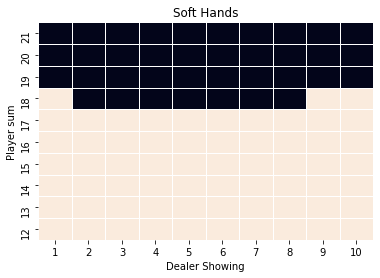

In [5]:
ax = sns.heatmap(PI[1, 8:], linewidths=.5, cbar=False)
ax.set(
    title='Soft Hands',
    xlabel='Dealer Showing', 
    ylabel='Player sum', 
    xticklabels=list(range(1, 11)),
    yticklabels=list(range(12, 22)))
ax.invert_yaxis()

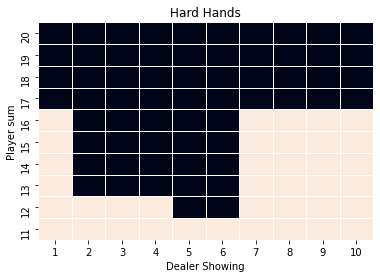

In [6]:
ax = sns.heatmap(PI[0, 7:-1], linewidths=.5, cbar=False)
ax.set(
    title='Hard Hands',
    xlabel='Dealer Showing', 
    ylabel='Player sum', 
    xticklabels=list(range(1, 11)),
    yticklabels=list(range(11, 21)))
ax.invert_yaxis()